In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

Train Data (GUIDE_Train.csv)

In [68]:
def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df

In [69]:
chunks = []
train_dataset = "GUIDE_Train.csv"
# Reading the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
train_data = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [163]:
print(train_data.shape)

(9516837, 45)


In [164]:
train_data.head(10)

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,180388628218,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,31,6,3
1,455266534868,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
2,1056561957389,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
3,1279900258736,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
4,214748368522,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
5,1322849927433,11,417400,825450,2024-06-10T13:30:56.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,8,6,3
6,163208760309,522,566,705663,2024-06-14T23:19:45.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
7,1400159339557,125,38679,47423,2024-06-06T13:39:23.000Z,313,3919,Exfiltration,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630
8,1219770713645,21,414,197969,2024-06-09T10:21:29.000Z,3,4,SuspiciousActivity,NaN,BenignPositive,...,NaN,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630
9,1073741827836,72,70,831157,2024-06-08T02:08:01.000Z,4,3,InitialAccess,NaN,TruePositive,...,NaN,NaN,5,66,NaN,NaN,NaN,242,1445,10630


In [165]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')

In [73]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [74]:
train_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,...,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06,9.516837e+06
mean,8.425494e+11,1.815800e+02,7.066349e+04,4.065188e+05,1.106724e+02,2.947315e+03,9.566476e+04,1.287191e+05,2.857506e+05,1.503317e+05,...,3.342790e+03,8.807955e+02,2.622621e+05,1.076172e+05,3.583477e+03,4.898537e+00,6.465558e+01,2.236742e+02,1.351488e+03,9.936183e+03
std,4.962499e+11,3.867784e+02,1.208369e+05,4.592827e+05,4.351038e+02,1.146150e+04,1.635288e+04,3.399208e+04,1.412240e+05,3.750795e+04,...,5.103381e+02,1.291083e+01,8.152956e+04,3.220835e+04,9.020262e+01,7.035099e-01,9.314929e+00,6.279729e+01,3.509808e+02,2.606812e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.123169e+11,1.000000e+01,5.040000e+02,2.324200e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.500000e+01,1.033600e+04,2.166520e+05,9.000000e+00,1.100000e+01,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.710000e+02,8.432900e+04,6.715770e+05,4.500000e+01,1.800000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.147000e+03,5.997060e+05,1.721456e+06,9.522000e+03,1.131740e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


Handling Missing Data

In [166]:
train_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       5468386
IncidentGrade           51340
ActionGrouped         9460773
ActionGranular        9460773
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        9420025
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          9441956
FileName                    0
FolderPath

In [167]:
# Droping Columns with More Than 55% Missing Values:
missing_percentage = train_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 55].index
train_data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columns dropped due to >55% missing values: {columns_to_drop.tolist()}")

Columns dropped due to >55% missing values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [168]:
print(train_data.shape)

(9516837, 35)


In [169]:
# Droping rows where 'IncidentGrade' is missing
train_data = train_data.dropna(subset=['IncidentGrade'])

"IncidentGrade," We can't have any missing data here because this is our target column.
Since imputing the target variable could produce inaccurate results, it is advisable to remove rows where the IncidentGrade is absent.

In [170]:
train_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [171]:
train_data.duplicated().sum()

np.int64(542692)

In [172]:
# Droping duplicate rows from the dataset
train_data = train_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {train_data.shape[0]}")

Number of rows after removing duplicates: 8922805


In [173]:
# Target variable distribution
print("Target variable distribution:")
train_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    3827800
TruePositive      3140126
FalsePositive     1954879
Name: count, dtype: int64

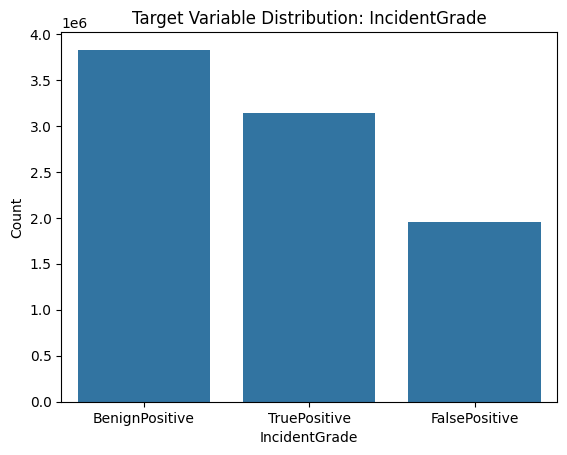

In [37]:
sns.countplot(data=train_data, x='IncidentGrade', order=train_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

Feature Exploration and Engineering

In [174]:
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'])
train_data['Year'] = train_data['Timestamp'].dt.year
train_data['Month'] = train_data['Timestamp'].dt.month
train_data['Day'] = train_data['Timestamp'].dt.day
train_data['Hour'] = train_data['Timestamp'].dt.hour

train_data.drop(columns='Timestamp',inplace=True)

In [175]:
train_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

In [176]:
print(train_data.shape)

(8922805, 38)


Exploratory Data Analysis (EDA)

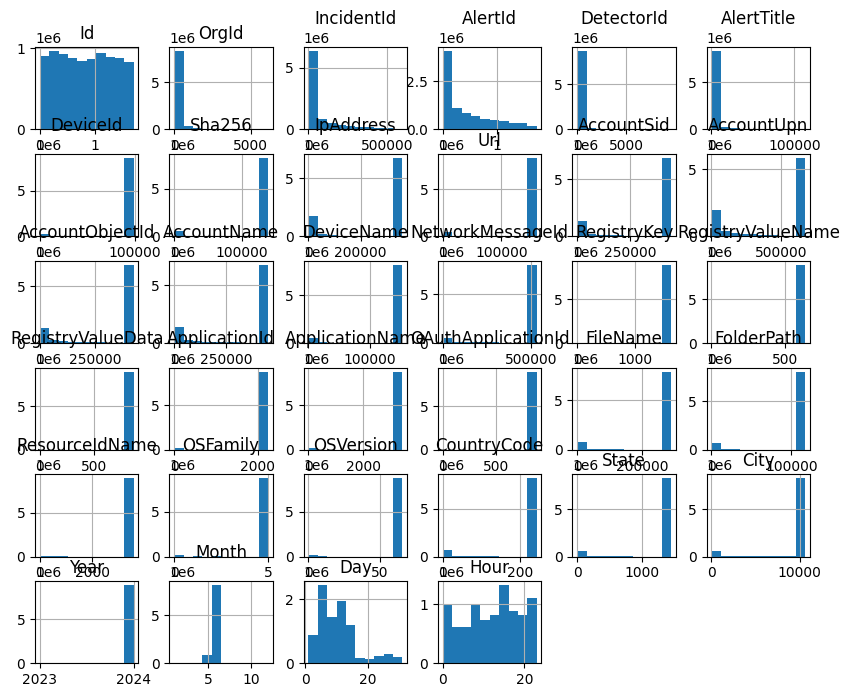

In [41]:
train_data.hist(figsize=(10,8))
plt.show()

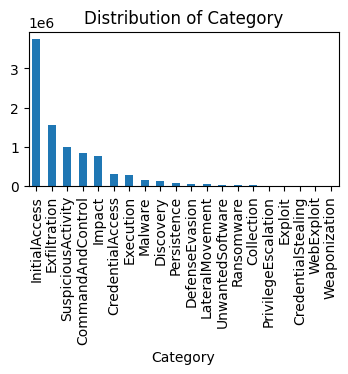

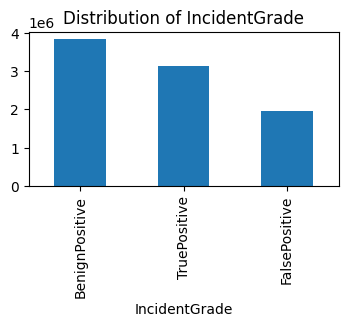

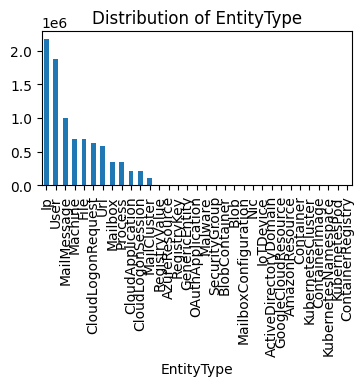

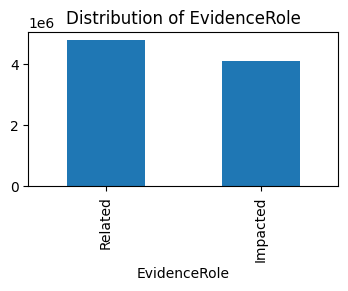

In [86]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = train_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    train_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

Visualizing the Data to Identify Outliers

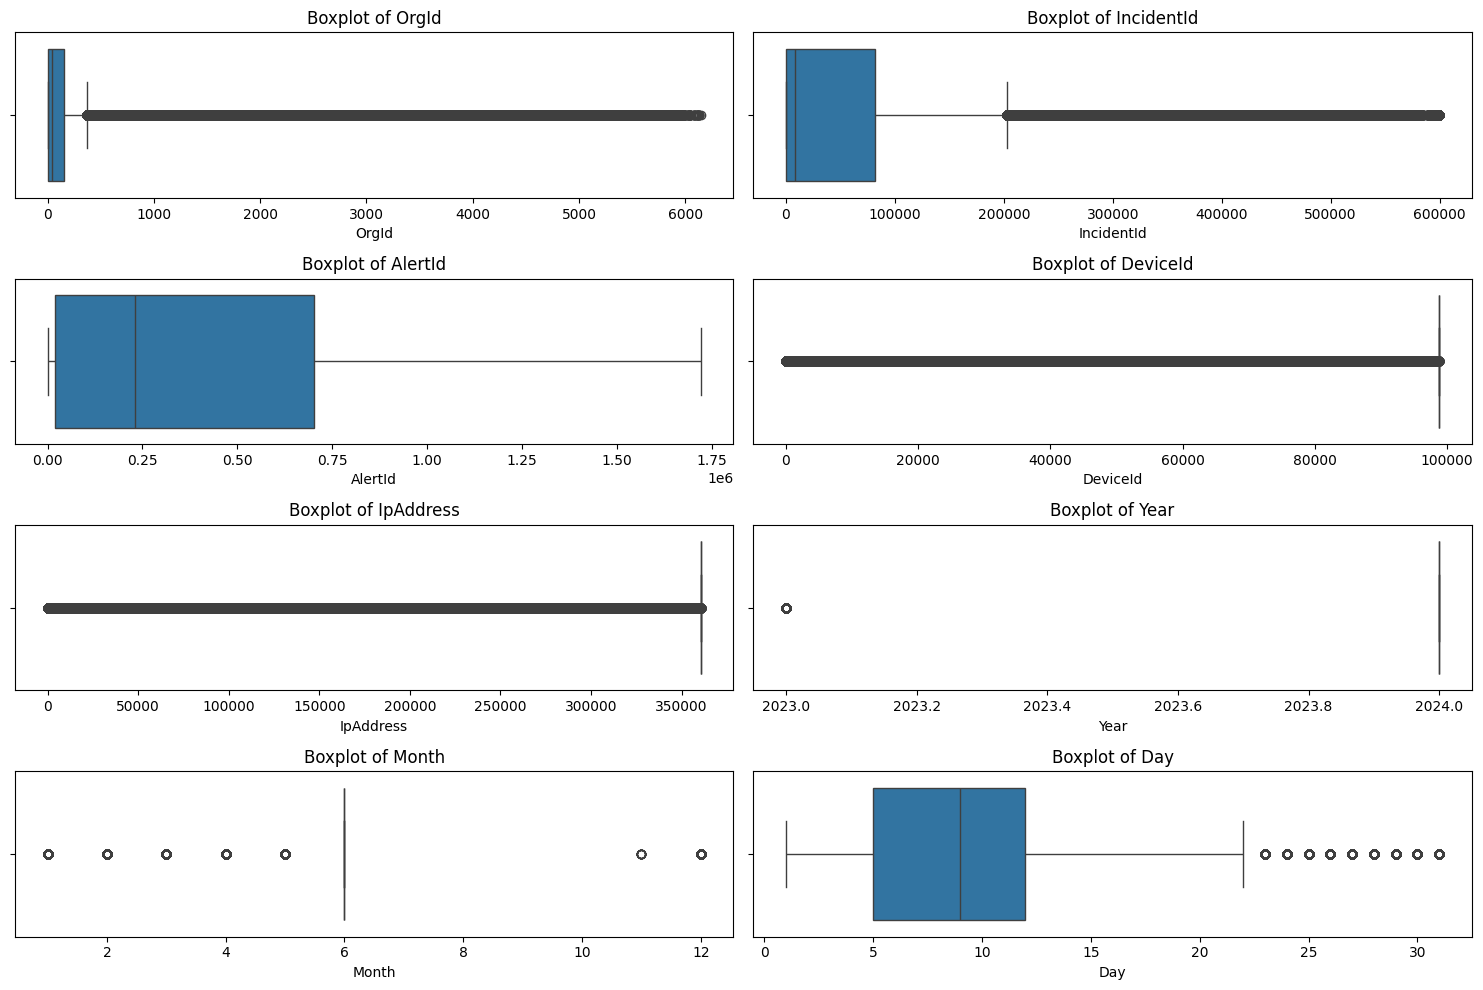

In [87]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=train_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

Correlation Analysis

In [177]:
train_data1 = train_data.copy()

In [178]:
# List of Numerical columns in DataFrame
numeric_columns = train_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])
# cheking num columns
numeric_columns.columns

Index(['Id', 'OrgId', 'DetectorId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ResourceIdName', 'OSFamily', 'OSVersion',
       'CountryCode', 'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

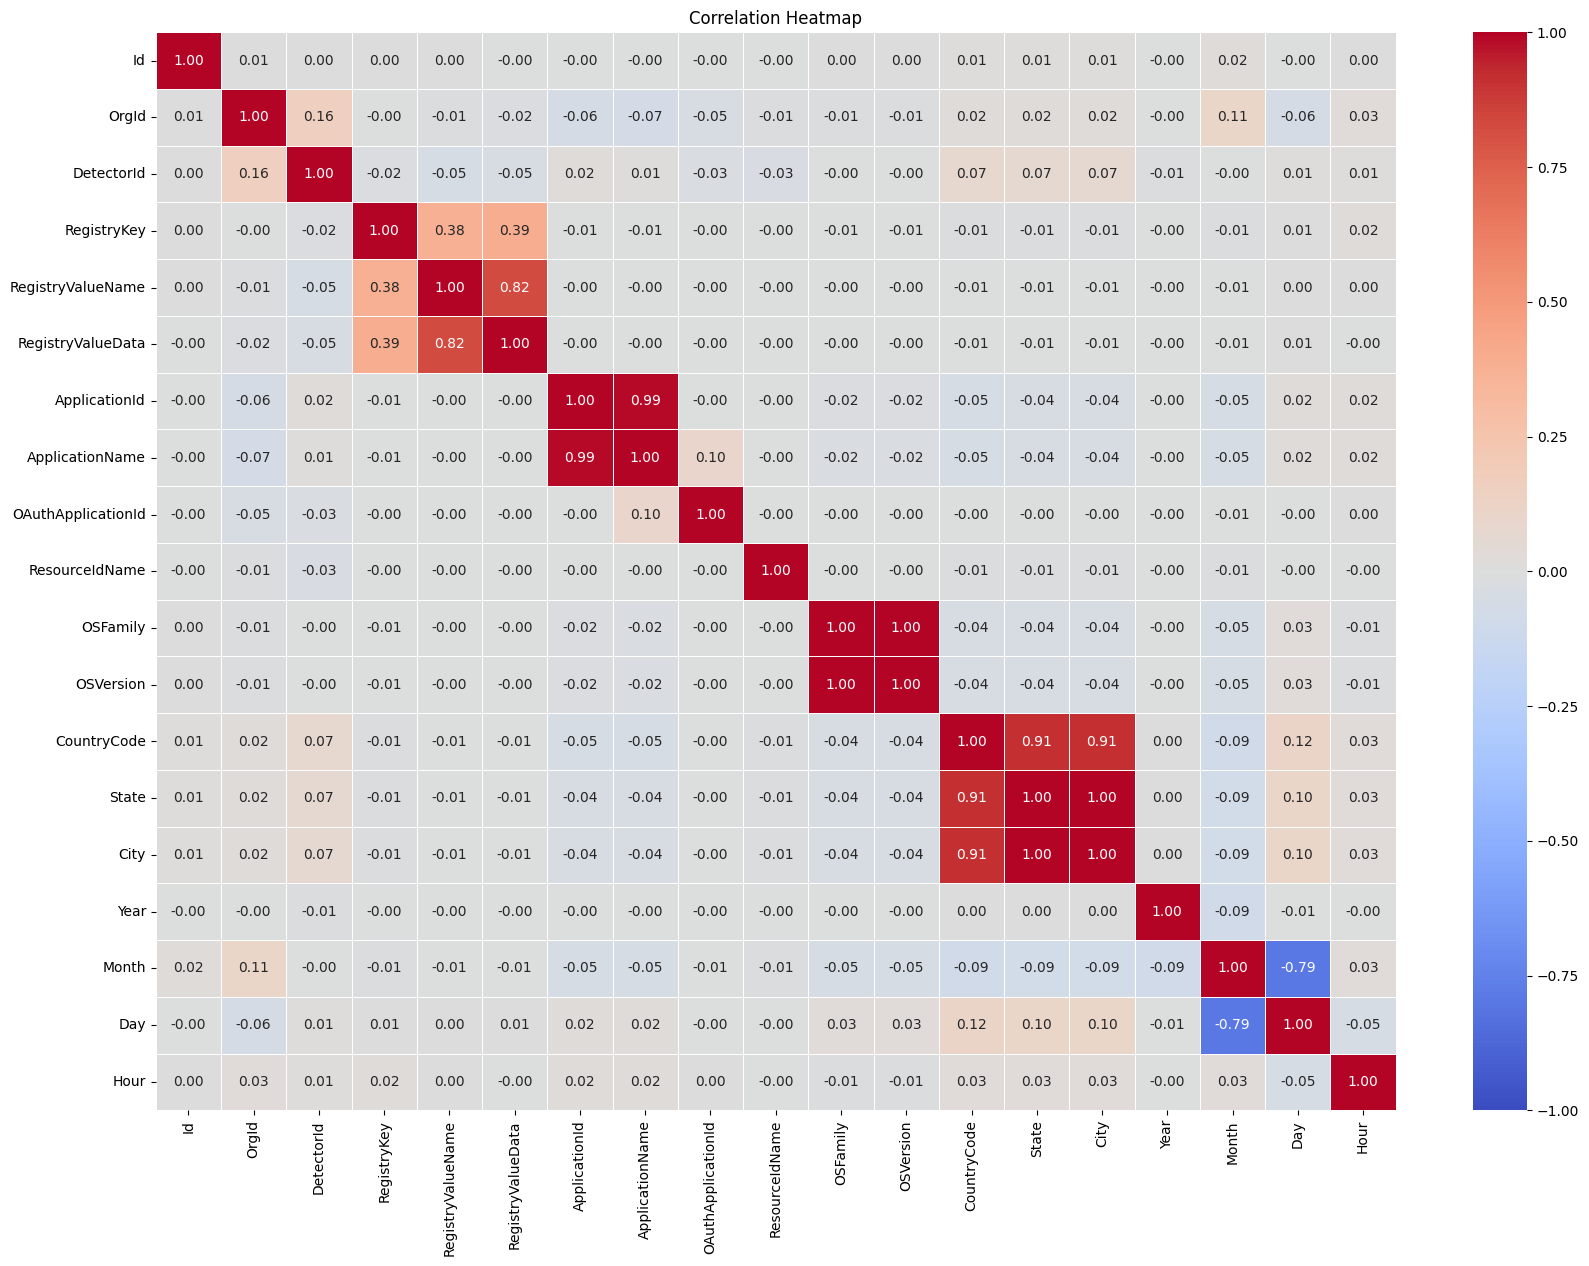

In [90]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

Feature Importance via Random Forest

In [180]:
# ID columns that don't help in model training
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId',
              'NetworkMessageId', 'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName']

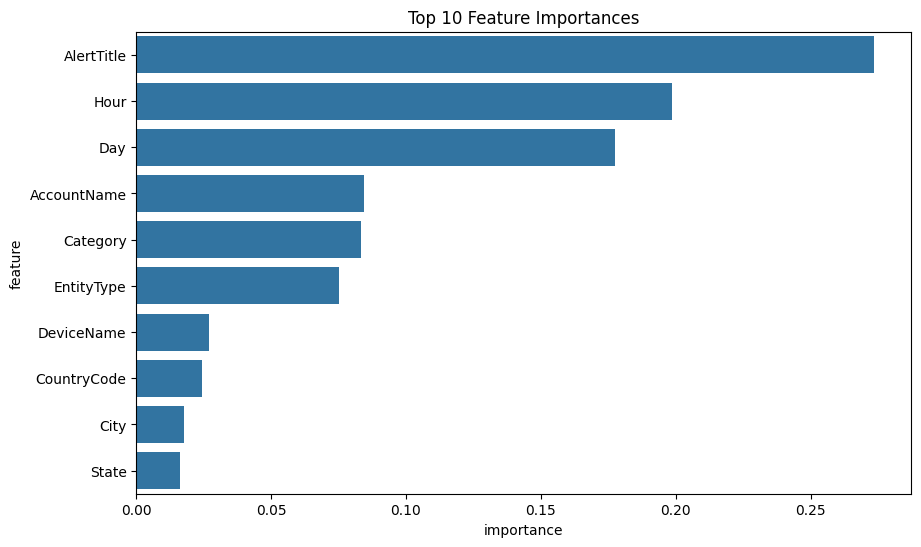

In [181]:
train_sample = train_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [182]:
#total df imp
imp_features= [
    'Alert Title', 'Hour', 'Day', 'AccountName', 'Category', 'EntityType', 'DeviceName', 'CountryCode', 'City', 'State']

In [183]:
print(train_data.columns)
train_data.shape

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8922805, 38)

In [184]:
train_data.nunique()

Id                     707108
OrgId                    5340
IncidentId             448901
AlertId               1248789
DetectorId               7813
AlertTitle              79952
Category                   20
IncidentGrade               3
EntityType                 33
EvidenceRole                2
DeviceId                75557
Sha256                 106416
IpAddress              285957
Url                    123252
AccountSid             353113
AccountUpn             524760
AccountObjectId        338252
AccountName            363254
DeviceName             114267
NetworkMessageId       375196
RegistryKey              1341
RegistryValueName         525
RegistryValueData         699
ApplicationId            1728
ApplicationName          2681
OAuthApplicationId        703
FileName               222085
FolderPath              87832
ResourceIdName           2283
OSFamily                    6
OSVersion                  58
CountryCode               236
State                    1368
City      

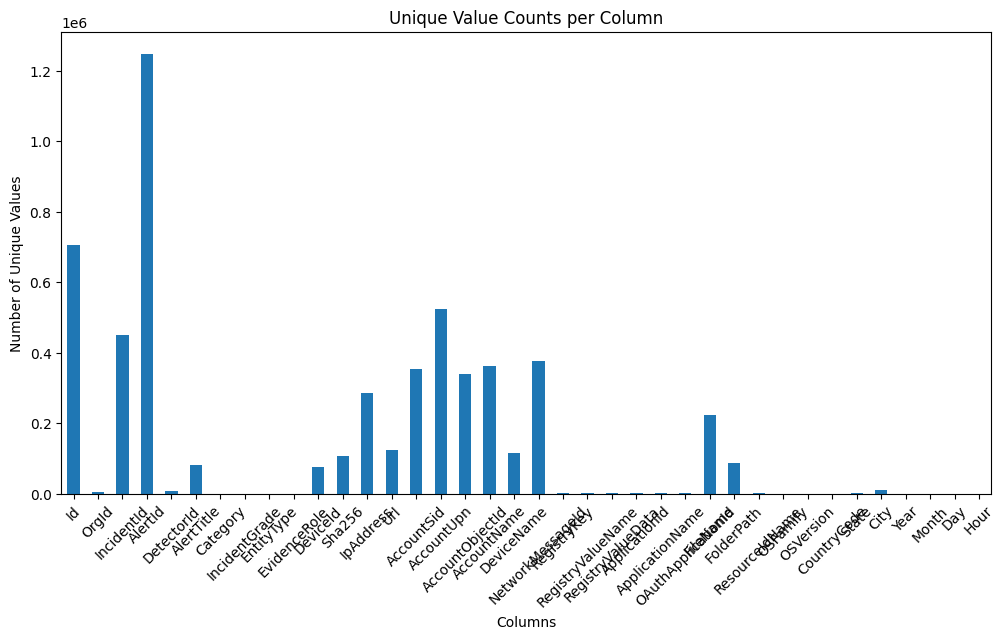

In [185]:
unique_counts = train_data.nunique()
unique_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Unique Value Counts per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=45)
plt.show()

In [97]:
train_data['AlertTitle'].value_counts()

AlertTitle
0         1320112
2          596458
1          480010
3          411725
4          411413
           ...   
111353          1
111201          1
88007           1
112485          1
110231          1
Name: count, Length: 79952, dtype: int64

In [98]:
train_data['Url'].value_counts()

Url
160396    8333372
0            8195
1            6607
2            5264
6            4238
           ...   
90529           1
120679          1
93239           1
107481          1
137238          1
Name: count, Length: 123252, dtype: int64

In [99]:
train_data['DeviceName'].value_counts()

DeviceName
153085    8228357
0            4376
1            3944
5            2153
4            2152
           ...   
71619           1
71462           1
82924           1
107496          1
116648          1
Name: count, Length: 114267, dtype: int64

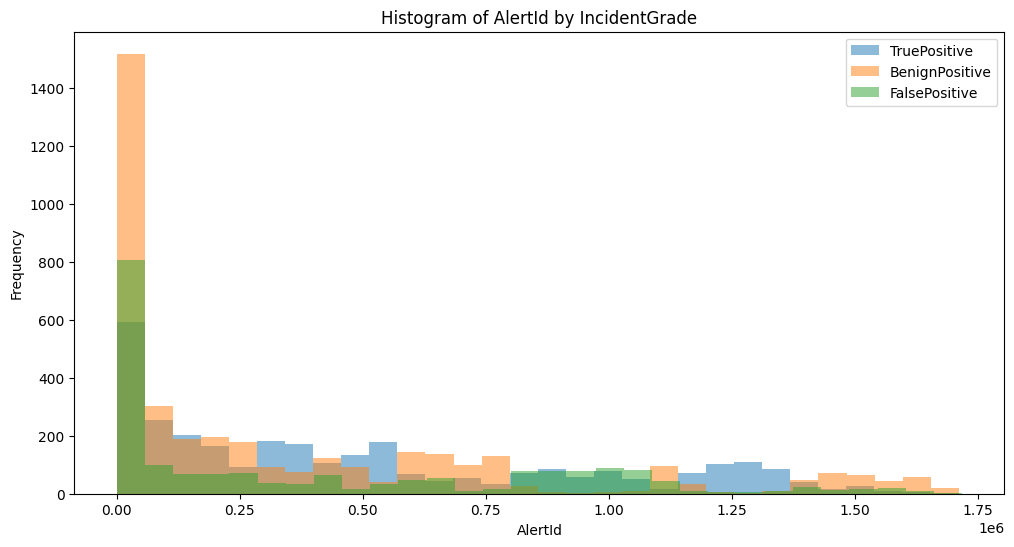

In [100]:
train_sample = train_data1.sample(frac=0.001, random_state=42)

plt.figure(figsize=(12, 6))
for grade in train_sample['IncidentGrade'].unique():
    subset = train_sample[train_sample['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

In [186]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
train_data.drop(columns=columns_to_drop, inplace=True)

In [187]:
print(train_data.columns)
train_data.shape

Index(['AlertTitle', 'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State',
       'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


(8922805, 16)

In [109]:
print(train_data.shape)

(8922805, 16)


Encoding Categorical Variables
    Label Encoding for Ordinal Variables
    One-hot encoding for nominal columns

In [188]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [189]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = train_data[column].value_counts()
    top_categories = category_counts.nlargest(5).index
    train_data[column] = train_data[column].where(train_data[column].isin(top_categories), 'Others')

# Now verifing the changes
train_data

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,Others,InitialAccess,TruePositive,Ip,Related,160396,453297,153085,5,Others,Others,3,2024,6,4,6
1,Others,Exfiltration,FalsePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,14,3
2,Others,InitialAccess,FalsePositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,13,4
3,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,10,16
4,Others,Execution,TruePositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9516832,Others,InitialAccess,TruePositive,CloudLogonRequest,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,15
9516833,2,CommandAndControl,BenignPositive,Url,Related,Others,453297,153085,5,242,1445,10630,2024,6,6,9
9516834,Others,Exfiltration,BenignPositive,MailMessage,Impacted,160396,453297,153085,5,242,1445,10630,2024,6,11,22
9516835,Others,Impact,BenignPositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,5,20,23


In [190]:
# Label Encoding for IncidentGrade (Target Variable)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_data['IncidentGrade'] = le.fit_transform(train_data['IncidentGrade'])

# One-Hot Encoding for nominal features
train_data = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

In [191]:
train_data.shape

(8922805, 154)

The cleaned train data set is saved as Joblib for further use.

In [192]:
train_data = train_data.reset_index(drop=True)

In [193]:
# Saveing the data using Joblib
joblib.dump(train_data, 'encoded_train_data.joblib')

['encoded_train_data.joblib']

In [194]:
# Loading the data using Joblib
train_data = joblib.load('encoded_train_data.joblib')

In [117]:
train_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_Others,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,False,True,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
4,2,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [195]:
train_data.shape

(8922805, 154)

In [196]:
print(train_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

1370.0215692520142 MB


Test Data

In [199]:
chunks = []
test_dataset = "GUIDE_Test.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(test_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
test_data = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [197]:
chunks = []
train_dataset2 = "GUIDE_Train.csv"
# Reading the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset2, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
train_data2 = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks

In [200]:

print(test_data.shape)

(4147992, 46)


In [122]:
test_data.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City,Usage
0,1245540519230,657,11767,87199,2024-06-04T22:56:27.000Z,524,563,LateralMovement,T1021;T1047;T1105;T1569.002,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Private
1,1400159342154,3,91158,632273,2024-06-03T12:58:26.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,0,0,NaN,Suspicious,Suspicious,242,1445,10630,Public
2,1279900255923,145,32247,131719,2024-06-08T03:20:49.000Z,2932,10807,LateralMovement,T1021;T1027.002;T1027.005;T1105,BenignPositive,...,NaN,5,66,NaN,Suspicious,Suspicious,242,1445,10630,Public
3,60129547292,222,15294,917686,2024-06-12T12:07:31.000Z,0,0,InitialAccess,T1078;T1078.004,FalsePositive,...,NaN,5,66,NaN,NaN,NaN,242,1445,10630,Public
4,515396080539,363,7615,5944,2024-06-06T17:42:05.000Z,27,18,Discovery,T1087;T1087.002,BenignPositive,...,Suspicious,5,66,NaN,NaN,NaN,242,1445,10630,Public


In [201]:
# Columns of both datasets
train_columns = set(train_data2.columns)
test_columns = set(test_data.columns)

# Difference columns
print("Columns in Train but not in Test:", train_columns - test_columns)
print("Columns in Test but not in Train:", test_columns - train_columns)

Columns in Train but not in Test: set()
Columns in Test but not in Train: {'Usage'}


In [202]:
# Problematic columns in both datasets
print(train_data2[list(train_columns - test_columns)].head())
print(test_data[list(test_columns - train_columns)].head())

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]
     Usage
0  Private
1   Public
2   Public
3   Public
4   Public


In [203]:
print("Target column in Train:", 'IncidentGrade' in train_data2.columns)
print("Target column in Test:", 'IncidentGrade' in test_data.columns)

Target column in Train: True
Target column in Test: True


In [204]:
print(test_data['Usage'].unique())
print(test_data['Usage'].head())

['Private', 'Public']
Categories (2, object): ['Private', 'Public']
0    Private
1     Public
2     Public
3     Public
4     Public
Name: Usage, dtype: category
Categories (2, object): ['Private', 'Public']


In [205]:
len(test_columns)

46

'Private' and 'Public' values in the Usage column are not included in the training dataset and do not provide any useful information for predicting IncidentGrade. As a result, it is removed to lessen model noise.

In [206]:
test_data.drop(columns='Usage',inplace=True)
# checking the shape of column
test_data.shape[1]

45

In [207]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int64   
 1   OrgId               int16   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int16   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       category
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         int32   
 22  DeviceName          int32   
 23  NetworkMessageId    int32   
 24

In [208]:
test_data.describe()

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,DeviceId,Sha256,IpAddress,Url,...,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City
count,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,...,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06,4.147992e+06
mean,8.462250e+11,1.756698e+02,6.780345e+04,4.072191e+05,1.008391e+02,2.529514e+03,9.575061e+04,1.283939e+05,2.873898e+05,1.504279e+05,...,3.342993e+03,8.808119e+02,2.618998e+05,1.074020e+05,3.583541e+03,4.899529e+00,6.466873e+01,2.222218e+02,1.344570e+03,9.883839e+03
std,4.923351e+11,3.708729e+02,1.178736e+05,4.550578e+05,4.082934e+02,1.044138e+04,1.615628e+04,3.457595e+04,1.400920e+05,3.734754e+04,...,5.096996e+02,1.238317e+01,8.208434e+04,3.260346e+04,9.012124e+01,7.001299e-01,9.269678e+00,6.499822e+01,3.626851e+02,2.696302e+03
min,1.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.209068e+11,8.000000e+00,4.110000e+02,2.365900e+04,2.000000e+00,2.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
50%,8.418136e+11,4.300000e+01,8.818000e+03,2.228970e+05,7.000000e+00,9.000000e+00,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
75%,1.271310e+12,1.730000e+02,7.944000e+04,6.711010e+05,3.900000e+01,1.160000e+02,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04
max,1.709397e+12,6.138000e+03,5.997000e+05,1.721457e+06,9.520000e+03,1.131690e+05,9.879900e+04,1.382680e+05,3.606060e+05,1.603960e+05,...,3.421000e+03,8.810000e+02,2.895730e+05,1.176680e+05,3.586000e+03,5.000000e+00,6.600000e+01,2.420000e+02,1.445000e+03,1.063000e+04


Handling Missing Data

In [209]:
test_data.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       2307104
IncidentGrade               0
ActionGrouped         4146079
ActionGranular        4146079
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 0
DeviceName                  0
NetworkMessageId            0
EmailClusterId        4106285
RegistryKey                 0
RegistryValueName           0
RegistryValueData           0
ApplicationId               0
ApplicationName             0
OAuthApplicationId          0
ThreatFamily          4116614
FileName                    0
FolderPath

In [210]:
# Droping Columns with More Than 55% Missing Values:
missing_percentage = test_data.isnull().mean() * 100
columns_to_drop = missing_percentage[missing_percentage > 55].index
test_data.drop(columns=columns_to_drop, axis=1, inplace=True)
print(f"Columns dropped due to >55% missing values: {columns_to_drop.tolist()}")

Columns dropped due to >55% missing values: ['MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId', 'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection', 'SuspicionLevel', 'LastVerdict']


In [211]:
test_data.isnull().sum()

Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64

In [212]:

test_data.duplicated().sum()

np.int64(225297)

In [213]:
# Droping duplicate rows from the dataset
test_data = test_data.drop_duplicates()

print(f"Number of rows after removing duplicates: {test_data.shape[0]}")

Number of rows after removing duplicates: 3922695


In [214]:
# Target variable distribution
print("Target variable distribution:")
test_data['IncidentGrade'].value_counts()

Target variable distribution:


IncidentGrade
BenignPositive    1630942
TruePositive      1422856
FalsePositive      868897
Name: count, dtype: int64

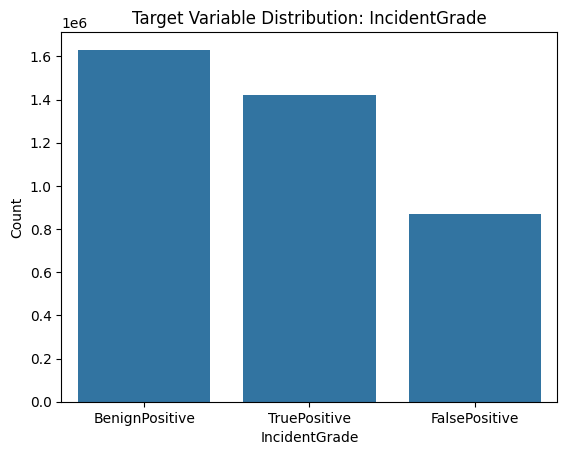

In [141]:
sns.countplot(data=test_data, x='IncidentGrade', order=test_data['IncidentGrade'].value_counts().index)
plt.title('Target Variable Distribution: IncidentGrade')
plt.xlabel('IncidentGrade')
plt.ylabel('Count')
plt.show()

Feature Exploration and Engineering

In [215]:
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'])
test_data['Year'] = test_data['Timestamp'].dt.year
test_data['Month'] = test_data['Timestamp'].dt.month
test_data['Day'] = test_data['Timestamp'].dt.day
test_data['Hour'] = test_data['Timestamp'].dt.hour

test_data.drop(columns='Timestamp',inplace=True)

In [216]:
test_data.columns

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')

Exploratory Data Analysis (EDA)

In [217]:
test_data1 =test_data.copy()

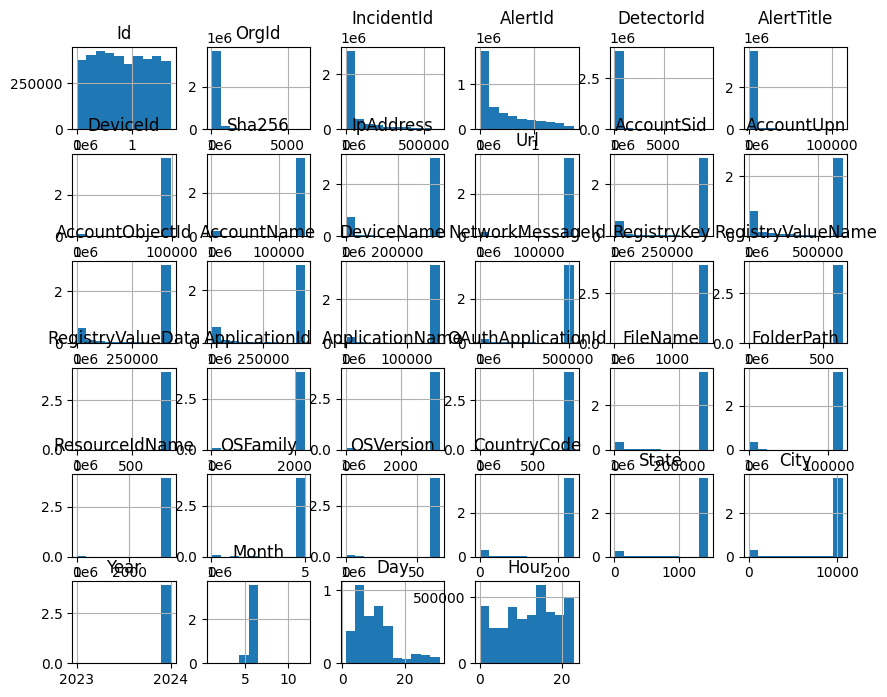

In [145]:
test_data.hist(figsize=(10,8))
plt.show()

In [218]:
# List of numeric columns in DataFrame
numeric_columns = test_data.select_dtypes(include=['int8','int16', 'int32', 'int64', 'float64'])

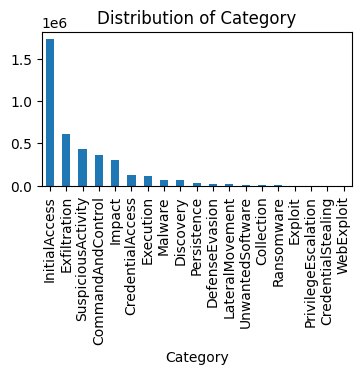

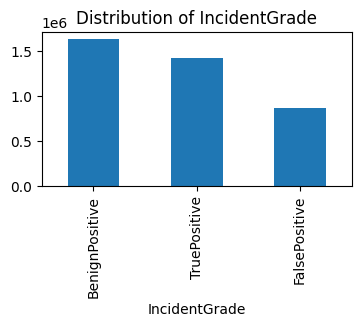

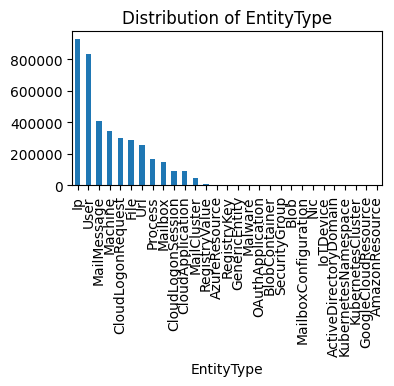

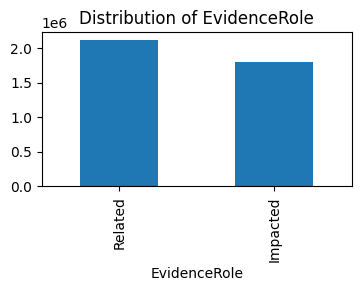

In [219]:
# Bar plot for categorical data
# List of categorical columns in DataFrame
categorical_columns = test_data.select_dtypes(include=['object','category'])

for col in categorical_columns:
    plt.figure(figsize=(4, 2))
    test_data[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.show()

Visualizing the Data to Identify Outliers

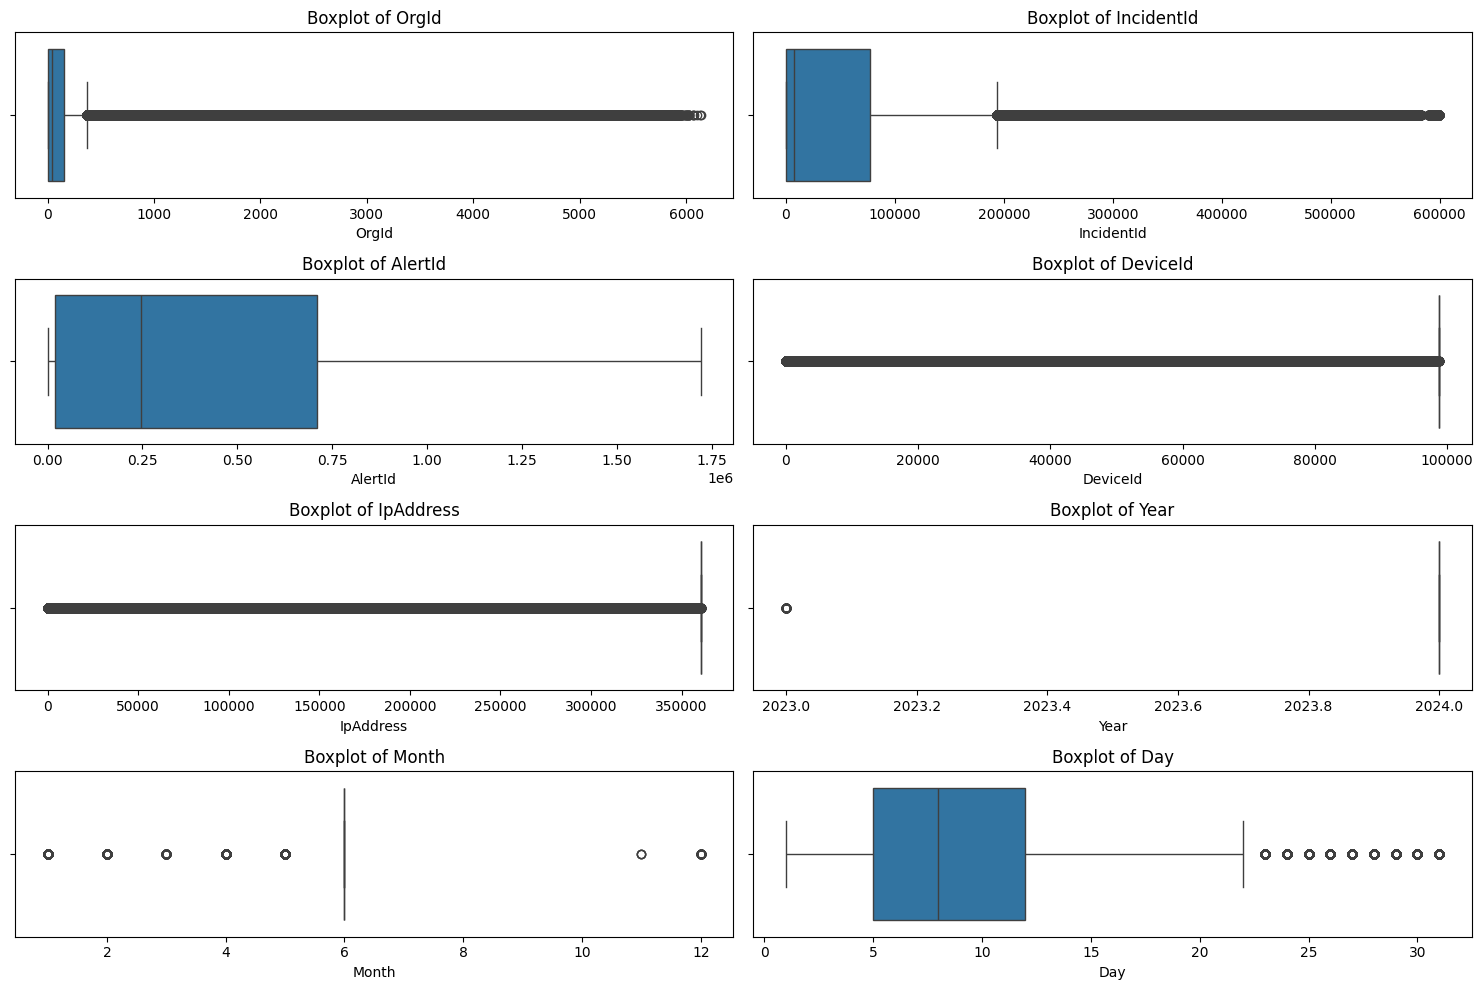

In [148]:
# Ploting box plots for numerical columns
numeric_cols = ['OrgId', 'IncidentId', 'AlertId', 'DeviceId', 'IpAddress', 'Year', 'Month', 'Day']
plt.figure(figsize=(15, 10))
num_plots = len(numeric_cols)
rows = (num_plots + 1) // 2

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=test_data[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

Correlation Analysis

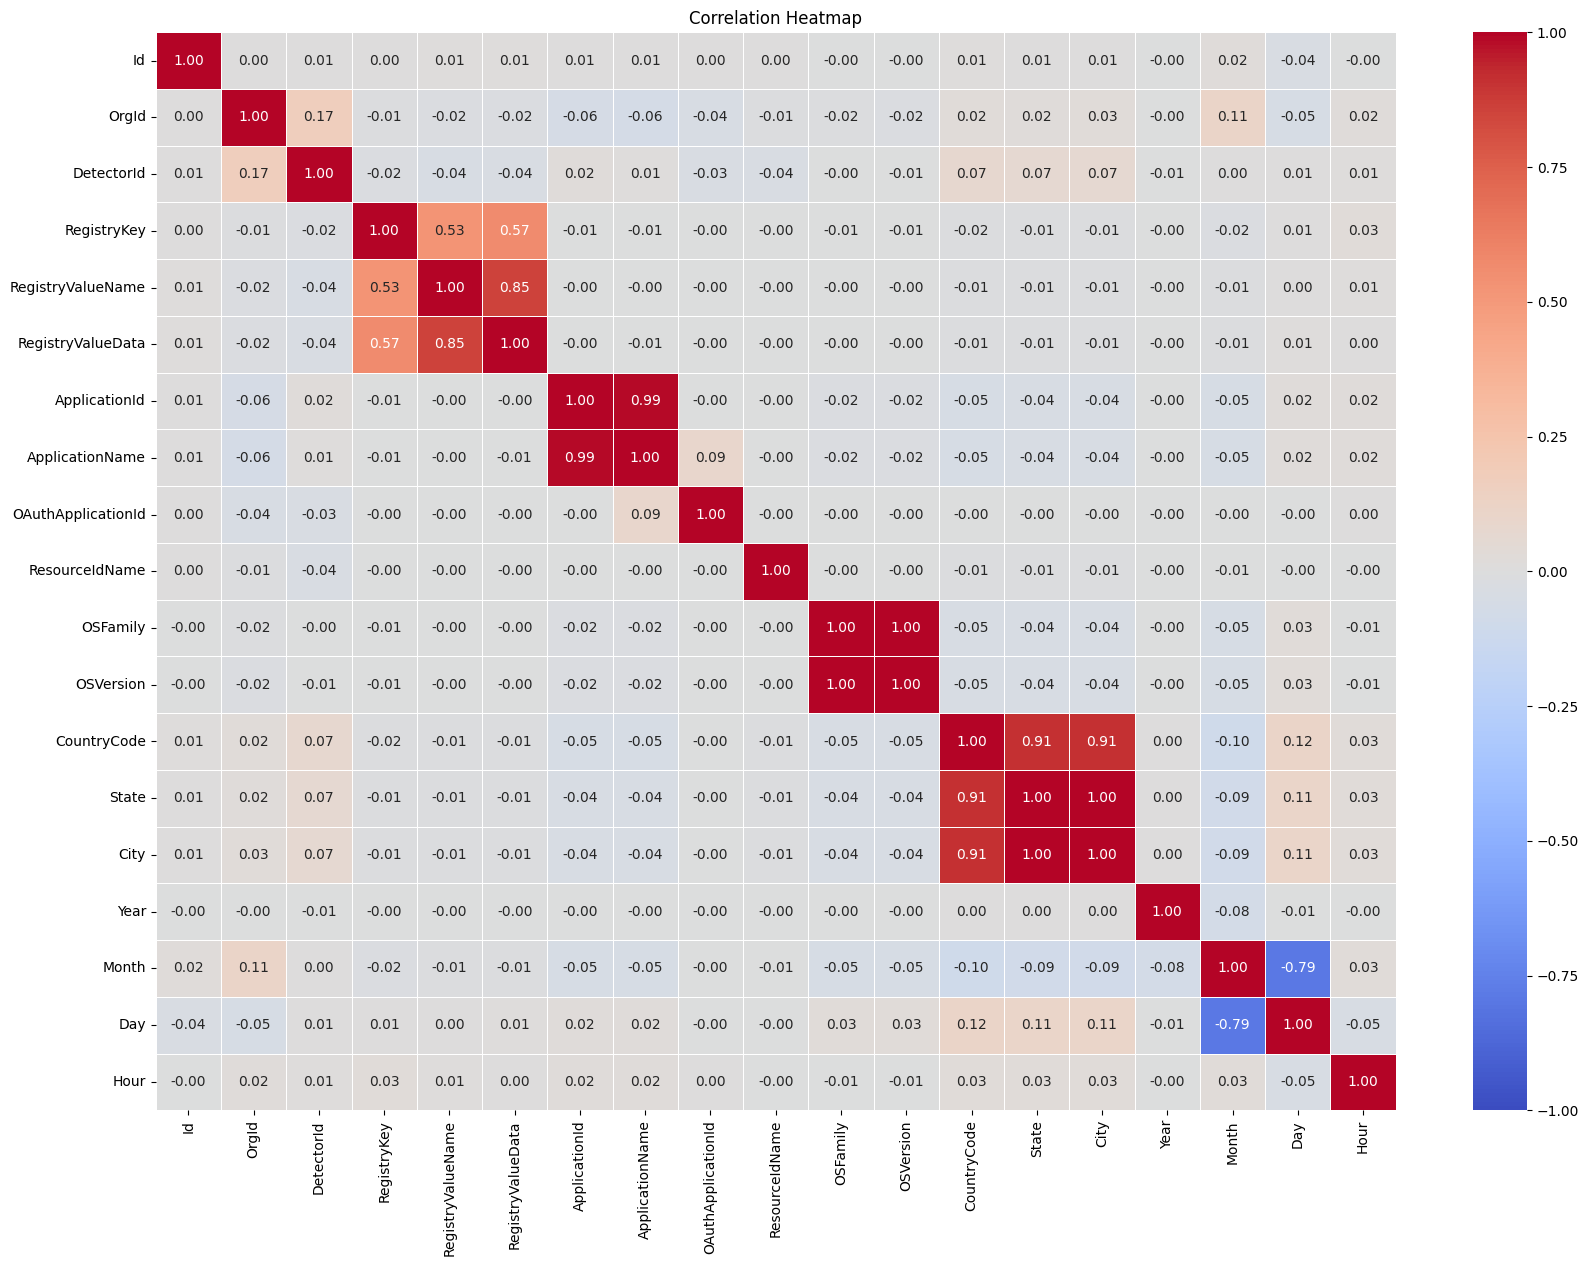

In [149]:
# heatmap visualization
plt.figure(figsize=(20, 14))
sns.heatmap(numeric_columns.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

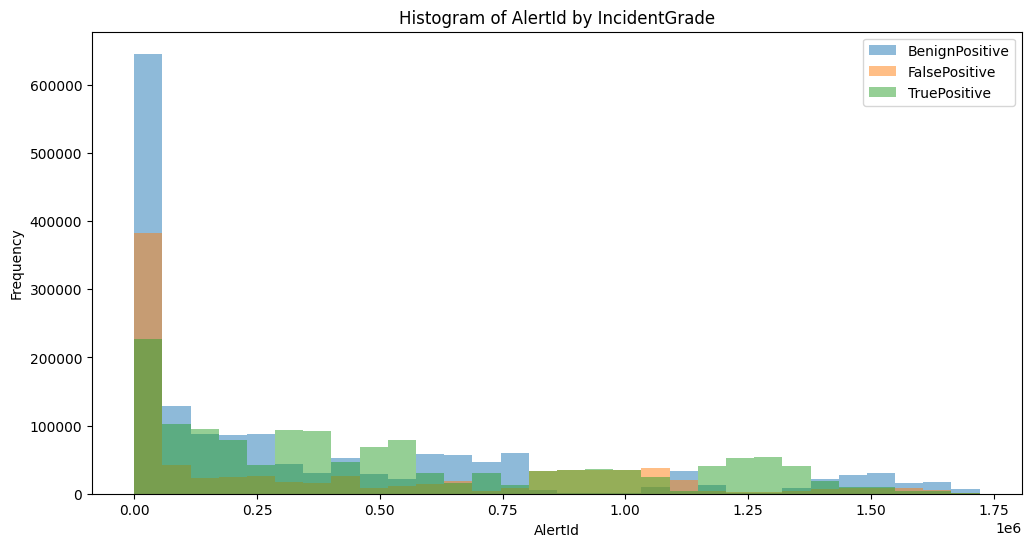

In [150]:
plt.figure(figsize=(12, 6))
for grade in test_data['IncidentGrade'].unique():
    subset = test_data[test_data['IncidentGrade'] == grade]
    plt.hist(subset['AlertId'], bins=30, alpha=0.5, label=grade)

plt.xlabel('AlertId')
plt.ylabel('Frequency')
plt.title('Histogram of AlertId by IncidentGrade')
plt.legend()
plt.show()

Feature Importance via Random Forest

In [220]:
print(test_data.columns)
len(test_data.columns)

Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'AlertTitle',
       'Category', 'IncidentGrade', 'EntityType', 'EvidenceRole', 'DeviceId',
       'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'RegistryKey', 'RegistryValueName', 'RegistryValueData',
       'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 'FileName',
       'FolderPath', 'ResourceIdName', 'OSFamily', 'OSVersion', 'CountryCode',
       'State', 'City', 'Year', 'Month', 'Day', 'Hour'],
      dtype='object')


38

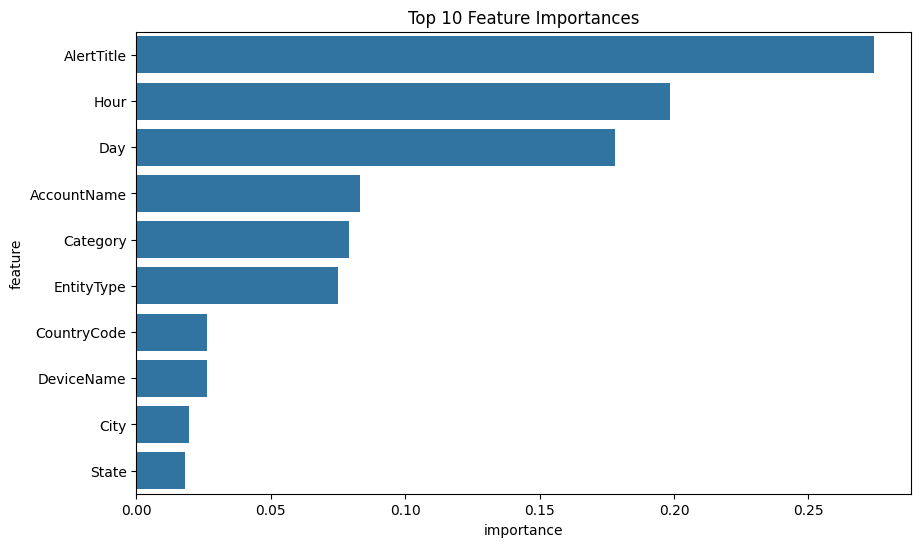

In [221]:
test_sample = test_data.sample(frac=0.001, random_state=42)
X = train_sample.drop(id_columns + ['IncidentGrade'], axis=1, errors='ignore')
y = train_sample['IncidentGrade']

non_numeric_cols = X.select_dtypes(exclude=['number']).columns
le = LabelEncoder()
for col in non_numeric_cols:
    X[col] = le.fit_transform(X[col].astype(str))

# Random Forest model
rf = RandomForestClassifier()
rf.fit(X, y)
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [222]:
# These features have minimal importance or are unlikely to impact your classification outcome
columns_to_drop = [
    'Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DetectorId','Sha256', 'IpAddress', 
    'AccountSid', 'AccountUpn', 'AccountObjectId', 'DeviceId', 'NetworkMessageId',
    'RegistryKey', 'RegistryValueName', 'RegistryValueData', 'ApplicationId', 'ApplicationName',
    'OAuthApplicationId', 'FileName', 'FolderPath', 'ResourceIdName', 'OSVersion'
]
test_data.drop(columns=columns_to_drop, inplace=True)

In [223]:
test_data.shape

(3922695, 16)

Encoding Categorical Variables
    Label Encoding for Ordinal Variables
    One-hot encoding for nominal columns

In [224]:
categorical_columns = ['AlertTitle', 'Category', 'EntityType', 'EvidenceRole',
       'Url', 'AccountName', 'DeviceName', 'OSFamily', 'CountryCode', 'State', 'City', 'Year',
       'Month', 'Day', 'Hour']

In [225]:
# List of columns to process
columns_to_group = ['AlertTitle', 'Url', 'AccountName', 'DeviceName', 'CountryCode', 'State', 'City']

# Looping through each column and grouping the less frequent values into "Others"
for column in columns_to_group:
    category_counts = test_data[column].value_counts()
    top_categories = category_counts.nlargest(5).index
    test_data[column] = test_data[column].where(test_data[column].isin(top_categories), 'Others')

# Now verifing the changes
test_data

,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,Url,AccountName,DeviceName,OSFamily,CountryCode,State,City,Year,Month,Day,Hour
0,Others,LateralMovement,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,22
1,2,CommandAndControl,BenignPositive,Machine,Impacted,160396,453297,Others,0,242,1445,10630,2024,6,3,12
2,Others,LateralMovement,BenignPositive,Process,Related,160396,453297,153085,5,242,1445,10630,2024,6,8,3
3,0,InitialAccess,FalsePositive,CloudLogonSession,Related,160396,453297,153085,5,242,1445,10630,2024,6,12,12
4,Others,Discovery,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,6,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147985,Others,Malware,BenignPositive,Machine,Impacted,160396,453297,4,0,242,1445,10630,2024,6,3,20
4147987,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,3
4147988,Others,InitialAccess,BenignPositive,User,Impacted,160396,Others,153085,5,242,1445,10630,2024,6,4,19
4147989,Others,CommandAndControl,FalsePositive,Ip,Related,160396,453297,153085,5,242,1445,10630,2024,6,15,0


In [226]:
# Label Encoding for IncidentGrade (Target Variable)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_data['IncidentGrade'] = le.fit_transform(test_data['IncidentGrade'])

# One-Hot Encoding for nominal features
test_data = pd.get_dummies(test_data, columns=categorical_columns, drop_first=True)

In [227]:
test_data.shape

(3922695, 148)

The cleaned test data set is saved as Joblib for further use.

In [228]:
print(train_data.shape)
print(test_data.shape)

(8922805, 154)
(3922695, 148)


In [229]:
train_data, test_data = train_data.align(test_data, join='left', axis=1)
test_data.fillna(0, inplace=True)

In [230]:
test_data.shape

(3922695, 154)

In [231]:
test_data = test_data.reset_index(drop=True)
# Saveing the data using Joblib
joblib.dump(test_data, 'encoded_test_data.joblib')


['encoded_test_data.joblib']

In [232]:
# Loading the data using Joblib
test_data = joblib.load('encoded_test_data.joblib')

In [233]:
test_data.head()

,IncidentGrade,AlertTitle_1,AlertTitle_2,AlertTitle_3,AlertTitle_4,AlertTitle_Others,Category_CommandAndControl,Category_CredentialAccess,Category_CredentialStealing,Category_DefenseEvasion,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,0,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [234]:
print(test_data.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

864.1649980545044 MB
